# Exploring LP price ranges for efficient capital deployment

Import relevant packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

### Replicating deposit amounts given an LP price range
Compare to https://app.uniswap.org/#/pool

In [2]:
def calc_balances(p: float, lower: float, upper: float, capital: float) -> None:
    """
    Calculates deposit amounts for arbitrary tokens x and y given LP range and current price
    
    :p current price (of x in terms of y)
    :lower lower price of LP range
    :upper upper price of LP range
    :capital amount of token 1
    """
    x_0 = (capital / p) / 2 # Split capital 50/50 between x and y
    y_0 = capital / 2

    # LP deposit amount - see 3.2.3 of https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf
    L_x = x_0 * ((math.sqrt(p)*math.sqrt(upper)) / (math.sqrt(upper) - math.sqrt(p)))
    L_y = y_0 / (math.sqrt(p) - math.sqrt(lower))
    L = min(L_x, L_y)

    x_1 = L * (math.sqrt(upper) - math.sqrt(p)) / (math.sqrt(p) * math.sqrt(upper))
    y_1 = L * (math.sqrt(p) - math.sqrt(lower))
    pos = x_1 * p + y_1 # in token y
    round_factor = 3
    print(f"x0: {round(x_0, round_factor)}, x1: {round(x_1, round_factor)}, y0: {round(y_0, round_factor)}, y1: {round(y_1, round_factor)}, LP value: {round(pos, round_factor)}")
    print(f"Unused capital: {round(capital - pos)} = {round(((capital - pos) / capital) * 100, 1)}% of capital (units in quote asset) \n")

Try playing around with the parameters p and perc!

In [4]:
# Correct strategy: upper is p * 1.3 and lower is p / 1.3
p = 1_000
perc = 30

r = 1 + (perc / 100)
calc_balances(p, p/r, p*r, 2*p)

# Incorrect strategy: upper is p + 30% and lower is p - 30%
s = 1 - (perc / 100)
t = 1 + (perc / 100)
calc_balances(p, p*s, p*t, 2*p)

x0: 1.0, x1: 1.0, y0: 1000.0, y1: 1000.0, LP value: 2000.0
Unused capital: 0 = 0.0% of capital (units in quote asset) 

x0: 1.0, x1: 0.753, y0: 1000.0, y1: 1000.0, LP value: 1752.675
Unused capital: 247 = 12.4% of capital (units in quote asset) 



### Intuition -  Plotting tick against price
Make sure to have the Panoptic style sheet downloaded!
https://github.com/panoptic-labs/research/tree/main/stylesheet

In [5]:
# Use Panoptic stylesheet - replace with where you saved it on your local directory
plt.style.use('../../stylesheet/panoptic-dark-2:1.mplstyle')

class LP_Range:
    """Class for plotting LP price range and corresponding ticks"""
    BASE = 1.0001 # UniV3 base of exponent

    @staticmethod
    def convert_tick_to_price(tick: int) -> float:
        """Converts tick to price"""
        return LP_Range.BASE ** tick

    @staticmethod
    def convert_price_to_tick(price: float) -> int:
        """Converts price to tick"""
        return round(math.log(price, LP_Range.BASE))

    @staticmethod
    def calc_tick_diff(price: float, perc: float) -> int:
        """Calculates difference in ticks"""
        tick = LP_Range.convert_price_to_tick(price)
        upper = price * (perc / 100 + 1)
        tick_u = LP_Range.convert_price_to_tick(upper)
        return tick_u - tick

    def plot_tick_price(self, p: float, perc: float, y_u: float=0.7, y_l: float=0.24, width_u: float=6.5, width_l: float=5) -> None:
        """
        Plots relationship between tick and prices with regard to an efficient LP range for 50/50 capital deployment
        Assumes discrete ticks of size 1
        Note: you will need to adjust y_l, y_u, and widthB to correctly display the brackets on the y-axis

        :p current price
        :perc +/- percent range to LP (if 30% then enter "30")
        :y_u y-coord for upper bracket
        :y_l y-coord for lower bracket
        :width_u width for upper bracket
        :width_l width for lower bracket
        """

        tick = LP_Range.convert_price_to_tick(p)
        tick_diff = LP_Range.calc_tick_diff(p, perc)
        tick_u = tick + tick_diff
        tick_l = tick - tick_diff
        upper = LP_Range.convert_tick_to_price(tick_u)
        lower = LP_Range.convert_tick_to_price(tick_l)

        x_curve = np.linspace(tick_l, tick_u, 100)
        y_curve = LP_Range.convert_tick_to_price(x_curve)

        x = [tick, tick_u, tick_l]
        y = [p, upper, lower]

        ax = plt.axes()

        # Annotate x axis
        ax.annotate(f"- {tick_diff} ticks", xy=(0.27, -0.12), xytext=(0.27, -0.3),
                    fontsize=3, ha='center', va='bottom', xycoords='axes fraction', 
                    arrowprops=dict(arrowstyle='-[, widthB=14.5, lengthB=.5', lw=1.0, color='white'))
        ax.annotate(f"+ {tick_diff} ticks", xy=(0.725, -0.12), xytext=(0.725, -0.3),
                    fontsize=3, ha='center', va='bottom', xycoords='axes fraction', 
                    arrowprops=dict(arrowstyle='-[, widthB=14.5, lengthB=.5', lw=1.0, color='white'))
                    
        # Annotate y axis
        perc_comp = round((1 - (1 / ((perc / 100) + 1))) * 100, 1)
        ax.annotate(f"+ {perc}%", xy=(1.003, y_u), xytext=(1.07, y_u),
                    fontsize=3, ha='right', va='center', rotation='vertical', xycoords='axes fraction', 
                    arrowprops=dict(arrowstyle=f'-[, widthB={width_u}, lengthB=.5', lw=0.5, color='white'))
        ax.annotate(f"- {perc_comp}%", xy=(1.003, y_l), xytext=(1.07, y_l),
                    fontsize=3, ha='right', va='center', rotation='vertical', xycoords='axes fraction', 
                    arrowprops=dict(arrowstyle=f'-[, widthB={width_l}, lengthB=.5', lw=0.5, color='white'))

        plt.xticks([tick_l, tick, tick_u])
        plt.yticks([lower, p, upper])
        plt.xlabel('Tick')
        plt.ylabel('Price')

        plt.plot(x_curve, y_curve)
        plt.plot(x, y, 'o')

Try playing around with the price and percent_range parameters.

Key insight: notice how the "+/-" symmetry is preserved in tick space - this will be the case for any price and percent range!

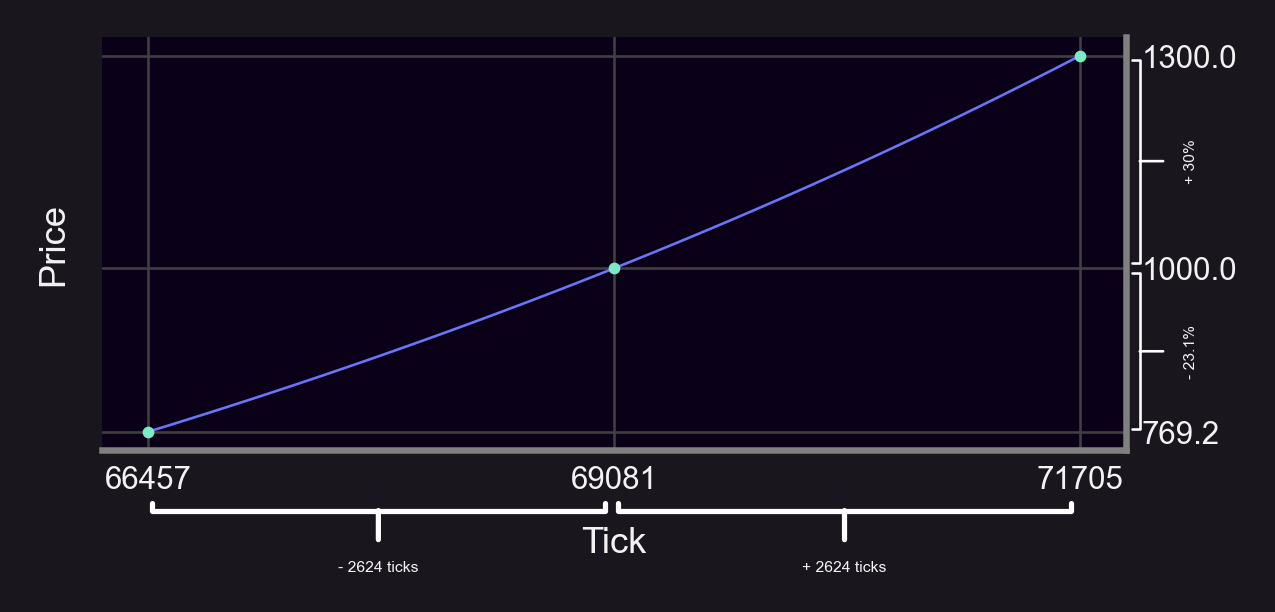

In [6]:
price = 1_000
percent_range = 30
LP_Range().plot_tick_price(p = price, perc = percent_range)

### Math Proof - Deriving p/r and p*r

Given total liquidity (L) for the price range [a, b]

And given price (p) of token x in terms of token y where $$p \in (a, b)$$

We have that the real balances of UniV3 pool tokens x and y are given by:

(see eqs. 11 & 12 in https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf)
$$x = L \times \frac{(\sqrt{b} - \sqrt{p})}{(\sqrt{p} \times \sqrt{b})}$$
$$y = L \times (\sqrt{p} - \sqrt{a})$$

Want to evenly split (50/50) our LP deposit between tokens x and y so we want:
$$x \times p = y$$
$$
    \begin{aligned}
        &\implies L \times \frac{(\sqrt{b} - \sqrt{p})}{(\sqrt{p} \times \sqrt{b})} \times p = L \times (\sqrt{p} - \sqrt{a}) \\
        &\implies  \frac{(\sqrt{b} - \sqrt{p})}{(\sqrt{p} \times \sqrt{b})} \times p = \sqrt{p} - \sqrt{a} \\
        &\implies \frac{(\sqrt{b} - \sqrt{p})}{\sqrt{b}} \times \sqrt{p} = \sqrt{p} - \sqrt{a} \\
        &\implies (\sqrt{b} - \sqrt{p}) \times \sqrt{p} = \sqrt{pb} - \sqrt{ab} \\
        &\implies \sqrt{pb} - p = \sqrt{pb} - \sqrt{ab} \\
        &\implies p = \sqrt{ab} \\
    \end{aligned}
$$
Express a and b as $$a = p\times s \text{ and } b = p\times r$$
where $$r, s \in \R$$

Plugging in, we obtain
$$
    \begin{aligned}
        p &= \sqrt{ab} \\
        &= \sqrt{(sp)(rp)} \\
        &= p\sqrt{rs}
    \end{aligned}
$$
$$
    \begin{aligned}
        &\implies 1 = \sqrt{rs} \\
        &\implies 1 = rs \\
        &\implies s = \frac{1}{r}
    \end{aligned}
$$
Hence,
$$a = \frac{p}{r} \text{ and } b = pr$$
